In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_validate
import torch
from sklearn.model_selection import train_test_split
from torch import optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
train_df = pd.read_csv("./C01_train_encoded.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 15 columns):
datetime            207 non-null object
y                   207 non-null float64
dateinterval        207 non-null float64
dayofmonth          207 non-null float64
weekofyear          207 non-null float64
dayofweek           207 non-null float64
soldout             207 non-null float64
kcal_fill_median    207 non-null float64
kcal_fill_mean      207 non-null float64
remarks             207 non-null float64
event               207 non-null float64
payday              207 non-null float64
weather             207 non-null float64
precipitation       207 non-null float64
temperature         207 non-null float64
dtypes: float64(14), object(1)
memory usage: 24.3+ KB


In [3]:
train_df.head(5)

,datetime,y,dateinterval,dayofmonth,weekofyear,dayofweek,soldout,kcal_fill_median,kcal_fill_mean,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90.0,0.32,0.52,0.34,0.35,0.001,0.51,0.5,0.001,0.001,0.001,0.4,0.48,0.51
1,2013-11-19,101.0,0.33,0.53,0.34,0.42,1.001,0.51,0.5,0.001,0.001,0.001,0.4,0.48,0.47
2,2013-11-20,118.0,0.33,0.54,0.34,0.50,0.001,0.51,0.5,0.001,0.001,0.001,0.4,0.48,0.45
3,2013-11-21,120.0,0.33,0.56,0.34,0.57,1.001,0.51,0.5,0.001,0.001,0.001,0.4,0.48,0.45
4,2013-11-22,130.0,0.33,0.57,0.34,0.64,1.001,0.51,0.5,0.001,0.001,0.001,0.4,0.48,0.46


In [4]:
# 全体の30%は検証用
train_data = train_df.values
X = train_data[:, 2:].astype(np.float)  # 正解データ列以外を抽出
Y = train_data[:, 1].astype(np.float)  # 正解データ列のみ抽出

Y = Y.reshape(Y.shape[0],1)

X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.3)

X_train = torch.tensor(X_train, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float) 
X_test = torch.tensor(X_test, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float) 

In [5]:
net = nn.Sequential(
    nn.Linear(X.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

In [6]:
#X_train = X_train.to("cuda:0")
#Y_train = Y_train.to("cuda:0")
#X_test = X_test.to("cuda:0")
#Y_test = Y_test.to("cuda:0")
#net.to("cuda:0")

In [7]:
# ソフトマックスクロスエントロピー
loss_fn = nn.MSELoss()

# Adam
optimizer = optim.Adam(net.parameters())

# 損失関数のログ
train_losses = []
test_losses = []

# 訓練用データでDataLoaderを作成
ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, shuffle=True) #batch_size=1,

In [8]:
for epoch in range(100):
    running_loss = 0.0
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

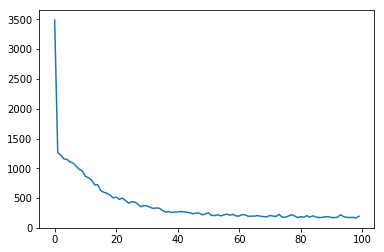

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(train_losses)

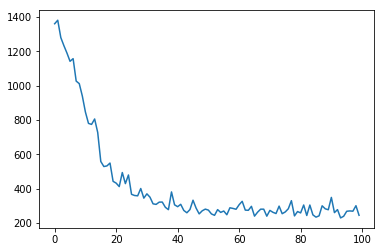

In [10]:
plt.plot(test_losses)

In [11]:
X_train = torch.tensor(X, dtype=torch.float)
Y_train = torch.tensor(Y, dtype=torch.float)
Y_train_pred = net(X_train)

In [12]:
Y_train_pred = Y_train_pred.detach().numpy()
Y_train_pred[:,0]

array([136.8873  , 140.3861  , 122.85197 , 119.80436 , 109.66498 ,
       150.84964 , 128.27    , 128.03052 , 115.662834, 107.45259 ,
       156.7035  , 146.75008 , 136.14943 , 115.56971 , 106.70988 ,
       156.5034  , 134.49803 , 126.52857 , 111.25369 , 107.65501 ,
       135.7465  , 140.83855 , 130.55841 , 131.99371 , 109.74854 ,
       122.26585 , 120.62594 , 116.09219 , 125.060936, 125.87866 ,
       116.913994,  95.04522 , 127.27446 , 125.29487 , 104.487495,
        88.86355 , 131.49892 , 125.143776, 114.07465 ,  96.8994  ,
       108.851616, 130.51323 , 113.00445 , 109.02831 ,  98.763504,
        91.80268 , 133.84348 , 135.54915 , 119.004   , 111.658134,
        98.41443 , 123.531715, 110.47508 , 102.73516 ,  96.956436,
       123.014336, 112.44663 , 103.40482 ,  97.976715, 117.34882 ,
       120.36742 ,  99.785286,  91.06392 ,  95.37774 ,  76.8729  ,
       118.893555, 116.11213 , 111.950714,  89.21611 ,  83.52627 ,
       116.326256,  99.91198 ,  83.572464,  88.34521 ,  70.134

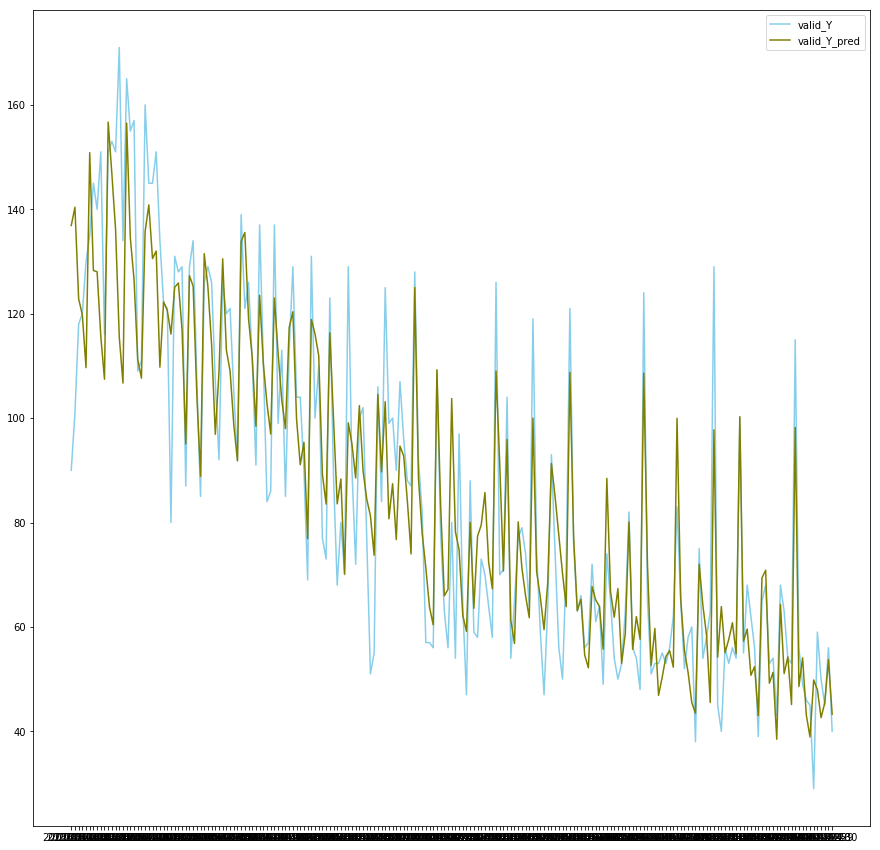

In [13]:
data = pd.DataFrame()
data['datetime'] = train_df['datetime']
data['valid_Y'] = train_df['y']
data['valid_Y_pred'] = pd.Series(Y_train_pred[:,0], name = 'valid_Y_pred')

plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.plot( 'datetime', 'valid_Y'     , data=data, color='skyblue')
plt.plot( 'datetime', 'valid_Y_pred', data=data, color='olive')
plt.legend()

In [14]:
test_df = pd.read_csv("./C01_test_encoded.csv")

In [15]:
test_df.head(5)

,datetime,y,dateinterval,dayofmonth,weekofyear,dayofweek,soldout,kcal_fill_median,kcal_fill_mean,remarks,event,payday,weather,precipitation,temperature
0,2014-10-1,NaN,0.62,0.33,0.63,0.50,1.001,0.55,0.55,0.001,0.001,0.001,0.72,0.48,0.51
1,2014-10-2,NaN,0.62,0.34,0.63,0.57,0.001,0.53,0.53,0.001,0.001,0.001,0.54,0.48,0.56
2,2014-10-3,NaN,0.62,0.35,0.63,0.64,0.001,0.49,0.49,0.001,0.001,0.001,0.45,0.48,0.62
3,2014-10-6,NaN,0.62,0.38,0.64,0.35,1.001,0.47,0.47,0.001,0.001,0.001,0.72,0.56,0.53
4,2014-10-7,NaN,0.62,0.39,0.64,0.42,0.001,0.58,0.59,0.001,0.001,0.001,0.45,0.48,0.54


In [16]:
test_data = test_df.values
X_test = test_data[:, 2:].astype(np.float)

In [17]:
X_test = torch.tensor(X_test, dtype=torch.float)
Y_test_pred = net(X_test)

In [18]:
Y_test_pred.shape

torch.Size([40, 1])

In [19]:
Y_test_pred = Y_test_pred.detach().numpy()
Y_test_pred[:,0]

array([ 53.928394,  42.504154,  35.5848  ,  62.014862,  46.933556,
        42.782772,  54.99706 ,  88.54244 ,  42.60789 ,  63.83543 ,
        39.357536,  32.532867,  53.483837,  52.602978,  45.791992,
        41.034153,  85.14557 ,  51.22772 ,  45.98251 ,  39.563984,
        37.677532,  36.80694 ,  44.514347,  45.879475,  40.781048,
        90.6182  ,  50.573246,  46.241154,  42.267838,  33.283066,
        32.581722,  89.2638  ,  78.09675 ,  71.66416 ,  65.726456,
       101.30988 ,  88.30482 ,  74.77895 ,  59.167202,  59.542885],
      dtype=float32)

In [20]:
data2 = pd.DataFrame()
data2['datetime'] = test_df['datetime']
data2['valid_Y_pred'] = pd.Series(Y_test_pred[:,0], name = 'valid_Y_pred')

data3 = pd.concat([data, data2], axis=0, sort=False)
data3[190:210]

,datetime,valid_Y,valid_Y_pred
190,2014-9-4,54.0,51.299221
191,2014-9-5,43.0,38.485409
192,2014-9-8,68.0,64.325096
193,2014-9-9,63.0,51.061199
194,2014-9-10,54.0,54.247295
195,2014-9-11,53.0,45.131969
196,2014-9-12,115.0,98.206749
197,2014-9-16,56.0,48.596325
198,2014-9-17,49.0,54.087353
199,2014-9-18,46.0,43.128933


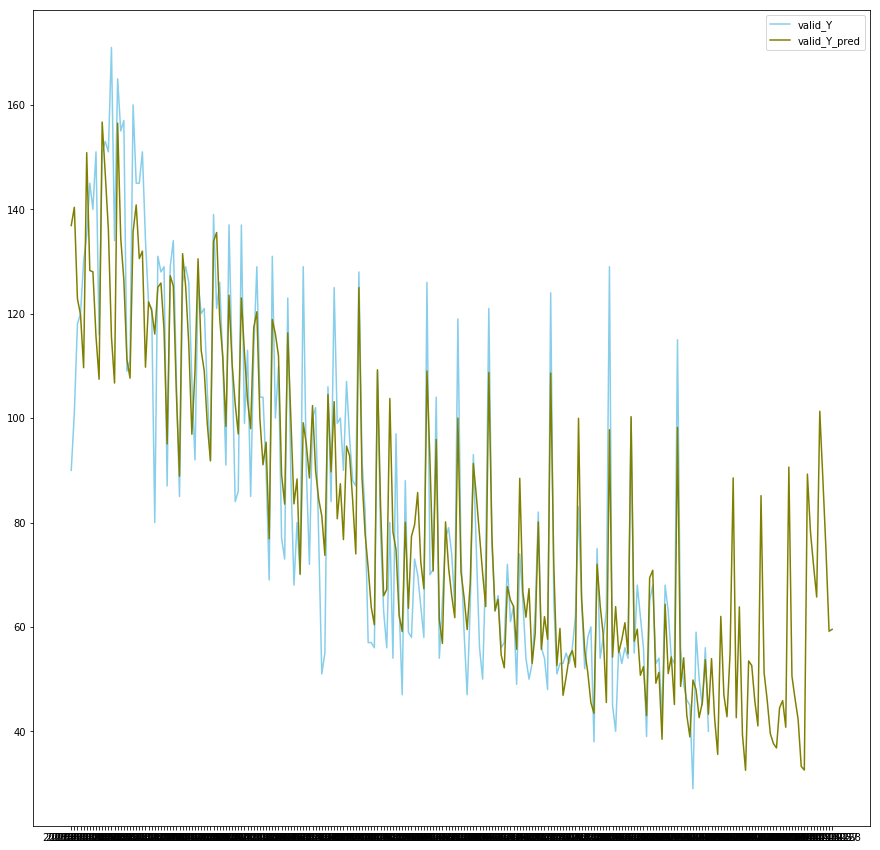

In [21]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.plot( 'datetime', 'valid_Y'     , data=data3, color='skyblue')
plt.plot( 'datetime', 'valid_Y_pred', data=data3, color='olive')
plt.legend()

In [22]:
Submission = pd.DataFrame()
Submission["datetime"] = test_df["datetime"]
Submission["y"] = Y_test_pred.astype(int)

In [23]:
import csv
Submission.to_csv("D02_Submission_1.csv", index=False, header=False)